In [1]:
import pandas as pd
from top2vec import Top2Vec
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.data_wrangling.load_data import load_political_quotes

# Load quotations from politicians from France, Italy, Germany, Spain and Poland

First, we load the quotes from politicians from France, Italy, Germany, Spain and Poland.

We selected these countries as they are quite similar, all of them are in the European Union and, in addition, they have a similar number of quotes.

In [17]:

quotes = []
countries = ['France', 'Italy', 'Germany', 'Spain', 'Poland']
for batch in load_political_quotes(country=countries, chunksize=20000):
    quotes.append(batch)

In [18]:
politician_quotes = pd.concat(quotes, axis=0, ignore_index=True)
politician_quotes = politician_quotes[['quotation', 'speaker', 'country', 'political_alignment', 'date', 'political_party']]
politician_quotes['date'] = pd.to_datetime(politician_quotes['date'])
politician_quotes


,quotation,speaker,country,political_alignment,date,political_party
0,"A big, fast, athletic guy that just doesn't kn...",Mark Helfrich,Germany,centre-right,2015-08-27 04:42:41,Christian Democratic Union
1,"I am confident enough, optimistic enough to sa...",Frank-Walter Steinmeier,Germany,centre-left,2015-12-01 08:47:00,Social Democratic Party of Germany
2,I am convinced that this conflict won't be sol...,Angela Merkel,Germany,centre-right,2015-02-07 10:20:03,Christian Democratic Union
3,action accomplished in the service of excellen...,François Hollande,France,centre-left,2015-03-06 13:14:59,Socialist Party
4,agreed that the E.U. should take further measu...,Angela Merkel,Germany,centre-right,2015-02-20 11:30:03,Christian Democratic Union
...,...,...,...,...,...,...
451124,The most important step in Libya now is the me...,Angela Merkel,Germany,centre-right,2020-01-24 16:30:48,Christian Democratic Union
451125,"very frank, very constructive and, I think ver...",Edouard Philippe,France,centre-right,2020-01-10 18:17:55,Union for a Popular Movement
451126,We have also touched on barriers related to ho...,Angela Merkel,Germany,centre-right,2020-02-06 04:12:00,Christian Democratic Union
451127,We have to create our own capability that best...,Emmanuel Macron,France,centre-left,2020-02-17 14:29:14,Socialist Party


# Run Top2Vec
### Configure Top2Vec

Here we configure Top2Vec and prepare the data. Top2Vec wants the documents and the ids as a list...

In [19]:
# SAMPLING
sampled_politician_quotes = politician_quotes.sample(130000, random_state=1)
documents_for_top2vec = sampled_politician_quotes['quotation'].tolist()
ids_for_top2vec  = sampled_politician_quotes.index.tolist()

excluded_indices = politician_quotes.index.isin(ids_for_top2vec)
not_sampled_politician_quotes = politician_quotes[~excluded_indices]
docs_for_top2vec_not_sampled = not_sampled_politician_quotes['quotation'].tolist()
ids_for_top2vec_not_sampled = not_sampled_politician_quotes.index.tolist()

Here we configure the dimensionality reduction(UMAP) and the clustering(HDBSCAN) steps.

In [5]:
umap_args = {'n_neighbors': 15,
             'n_components': 15,
             'metric': 'cosine'}
hdbscan_args = {'min_cluster_size': 15,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'#,'core_dist_n_jobs': 1
               }

The speed option chooses a preconfiguration of for doc2vec. Here we used the quickest preset. But this we could also  modify later in the top2vec code manually to get optimal results.

### Execute the pipeline(Doc2Vec, UMAP, HDBSCAN, AssignToTopics)

In [6]:
model = Top2Vec(documents_for_top2vec, document_ids=ids_for_top2vec, speed='learn',
                umap_args=umap_args, hdbscan_args=hdbscan_args, workers=8)

2021-12-12 15:45:12,209 - top2vec - INFO - Pre-processing documents for training
2021-12-12 15:45:19,395 - top2vec - INFO - Creating joint document/word embedding
2021-12-12 15:52:53,236 - top2vec - INFO - Creating lower dimension embedding of documents
2021-12-12 15:54:48,882 - top2vec - INFO - Finding dense areas of documents
2021-12-12 15:55:13,118 - top2vec - INFO - Finding topics


... and save the model for later.

In [7]:
model.save("all-years-doc2vec-sampled-without-uk")

### Collect the quotes in the topics of interest

In [20]:
# Load trained model
top2vec_model = Top2Vec.load("all-years-doc2vec-sampled-without-uk")

# Add documents not trained
top2vec_model.add_documents(docs_for_top2vec_not_sampled, doc_ids=ids_for_top2vec_not_sampled)


In [21]:
# Functions for visualization

def filter_quotes_by_custom_topic(dataframe, top2vec_model, topic_keywords, similarity_threshold = 0.22):
    doc_words, document_scores, document_ids = top2vec_model.search_documents_by_keywords(keywords=topic_keywords, num_docs=len(dataframe))
    positions = np.argwhere(document_scores > similarity_threshold).flatten()
    print("There are %d quotes above the threshold %.2f for the topic with the following keywords: %s" % (len(positions), similarity_threshold, topic_keywords[0]), end='')
    for keyword in topic_keywords[1:]:
        print(", %s" % keyword, end='')
    print(".")
    return dataframe[dataframe.index.isin(document_ids[positions])]

def filter_quotes_by_existent_topic(dataframe, top2vec_model, topic_id, similarity_threshold = 0.25):
    _, document_scores, document_ids = top2vec_model.search_documents_by_topic(topic_num=48, num_docs=len(dataframe))
    positions = np.argwhere(document_scores > similarity_threshold).flatten()
    print("There are %d quotes above the threshold %.2f for the topic with ID %s." % (len(positions), similarity_threshold, topic_id))
    return dataframe[dataframe.index.isin(positions)]

### Max Simon? Nazist general or CEO of a cannabis-related company?

In the following sections, we will analyze the quotes in certain topics.
In particular, one of the topics is related with cannabis and drugs liberalization.

In [22]:
drugs_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["cannabis", "drugs"])
drugs_quotes

There are 642 quotes above the threshold 0.22 for the topic with the following keywords: cannabis, drugs.


,quotation,speaker,country,political_alignment,date,political_party
245,"Drugs are reimbursed by taxpayers, so it's all...",Segolene Royal,France,centre-left,2015-02-23 10:39:13,Socialist Party
1944,significant improvement in the substance of wh...,Angela Merkel,Germany,centre-right,2015-02-20 13:15:22,Christian Democratic Union
2534,"The traditional methods didn't work,",Serge Klarsfeld,Germany,left-wing,2015-03-31 20:30:05,The Left
2589,"call for behavior that needs to be exemplary,",Francois Hollande,France,centre-left,2015-09-27 11:36:00,Socialist Party
3323,We have created the conditions for a continuou...,Johanna Wanka,Germany,centre-right,2015-05-18 00:00:00,Christian Democratic Union
...,...,...,...,...,...,...
450355,Such medical goods can only be exported with t...,Ursula von der Leyen,Germany,centre-right,2020-03-31 03:14:41,Christian Democratic Union
450536,"Until I get in to see my own cardiologist, I'm...",Thomas Bach,Germany,centre-right,2020-03-25 21:13:59,Free Democratic Party
450709,"Along with the municipal anti-pest team, I am ...",Benjamin Griveaux,France,centre-left,2020-02-06 10:57:36,Socialist Party
450994,important areas of medical production.,Peter Altmaier,Germany,centre-right,2020-04-08 06:31:26,Christian Democratic Union


However, we found that one of the most popular speaker in this topic was a Nazist general! We immediately found it really weird, therefore we decided to further investigate.
Let's show one of his quotes:

In [23]:
drugs_quotes[drugs_quotes.quotation == "We have developed two new Cannabis Certificate programs that are highly valuable to anyone seeking credibility, confidence, and skills within the cannabis industry,"]

,quotation,speaker,country,political_alignment,date,political_party
386461,We have developed two new Cannabis Certificate...,Max Simon,Germany,far-right,2019-03-11 16:46:00,National Socialist German Workers' Party (Nazi...


It's not very likely that a Nazist general said something like this.

Curious about this problem, we googled <b>Max Simon</b> and the second result was the CEO of the company <b>Green Flower</b>, leader in cannabis education.
We may have found the true Max Simon!


Indeed, we then searched for the same quote on <a href='https://quotebank.dlab.tools/search?target=quotation&text=We+have+developed+two+new+Cannabis+Certificate+programs+that+are+highly+valuable+to+anyone+seeking+credibility%2C+confidence%2C+and+skills+within+the+cannabis+industry%2C&from_date=2008-09-01&to_date=2020-04-17'>Quotebank</a> and the wikidata reference of the speaker links to the Nazist general, even if he obsiously is the CEO of this cannabis company.
Therefore, we will delete him from the dataset and exclude him.

We also observe that we were able to find him because he is from the USA, where the number of quotes of the speakers is much higher than in Europe.
Therefore, he showed up in the top speakers even if he has not many quotes.
Probably, if he were European, we would not have been able to find him and to point out this problem in the Quotebank dataset.

In [24]:
# Remove from the dataset Max Simon, CEO of cannabis company and not a Nazist!
max_simon_quotes = politician_quotes[politician_quotes.speaker == "Max Simon"]
politician_quotes = politician_quotes[politician_quotes.speaker != "Max Simon"]
top2vec_model.delete_documents(max_simon_quotes.index.tolist())
politician_quotes

,quotation,speaker,country,political_alignment,date,political_party
0,"A big, fast, athletic guy that just doesn't kn...",Mark Helfrich,Germany,centre-right,2015-08-27 04:42:41,Christian Democratic Union
1,"I am confident enough, optimistic enough to sa...",Frank-Walter Steinmeier,Germany,centre-left,2015-12-01 08:47:00,Social Democratic Party of Germany
2,I am convinced that this conflict won't be sol...,Angela Merkel,Germany,centre-right,2015-02-07 10:20:03,Christian Democratic Union
3,action accomplished in the service of excellen...,François Hollande,France,centre-left,2015-03-06 13:14:59,Socialist Party
4,agreed that the E.U. should take further measu...,Angela Merkel,Germany,centre-right,2015-02-20 11:30:03,Christian Democratic Union
...,...,...,...,...,...,...
451124,The most important step in Libya now is the me...,Angela Merkel,Germany,centre-right,2020-01-24 16:30:48,Christian Democratic Union
451125,"very frank, very constructive and, I think ver...",Edouard Philippe,France,centre-right,2020-01-10 18:17:55,Union for a Popular Movement
451126,We have also touched on barriers related to ho...,Angela Merkel,Germany,centre-right,2020-02-06 04:12:00,Christian Democratic Union
451127,We have to create our own capability that best...,Emmanuel Macron,France,centre-left,2020-02-17 14:29:14,Socialist Party


In [25]:
immigration_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["immigration", "migrants"])
europe_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["european"])
discrimination_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["discrimination", "racism", "gender", "equality"])
drugs_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["cannabis", "drugs"])
climate_change_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["climate", "change", "emissions"])
russia_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["russia", "putin"])
covid_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["coronavirus"])
terrorism_quotes = filter_quotes_by_custom_topic(politician_quotes, top2vec_model, topic_keywords=["terrorism"])

There are 3662 quotes above the threshold 0.22 for the topic with the following keywords: immigration, migrants.
There are 4891 quotes above the threshold 0.22 for the topic with the following keywords: european.
There are 3398 quotes above the threshold 0.22 for the topic with the following keywords: discrimination, racism, gender, equality.
There are 589 quotes above the threshold 0.22 for the topic with the following keywords: cannabis, drugs.
There are 4279 quotes above the threshold 0.22 for the topic with the following keywords: climate, change, emissions.
There are 2792 quotes above the threshold 0.22 for the topic with the following keywords: russia, putin.
There are 375 quotes above the threshold 0.22 for the topic with the following keywords: coronavirus.
There are 4443 quotes above the threshold 0.22 for the topic with the following keywords: terrorism.


In [26]:
# Save topics
immigration_quotes.to_csv('immigration_quotes')
europe_quotes.to_csv('europe_quotes')
discrimination_quotes.to_csv('immigration_quotes')
drugs_quotes.to_csv('discrimination_quotes')
climate_change_quotes.to_csv('drugs_quotes')
russia_quotes.to_csv('russia_quotes')
covid_quotes.to_csv('covid_quotes')
terrorism_quotes.to_csv('terrorism_quotes')

# Topic analysis

### Visualization function

Here we define some functions that will be needed for the visualization of the results.

In [27]:
# Distribution over time
def show_time_distribution(topic_name, df, country = None):
    sns.set_context('notebook')
    series = df["date"].dt.strftime('%Y-%b')
    series = series.groupby(series).count()
    date_range = pd.date_range('2015-01-01','2020-04-01',
              freq='MS').strftime("%Y-%b")
    series = series.reindex(date_range, fill_value=0)

    visualized_df = pd.DataFrame({'dates': series.index,
                        'counts': series.values
                       }, columns = ['dates','counts'])

    fig, ax = plt.subplots(figsize = (20,8))
    sns.barplot(x = "dates", y = "counts", data = visualized_df, color='cadetblue',
                      ci = None, ax=ax)
    ax.set_xticklabels(labels=visualized_df['dates'], rotation=45, ha='right')
    # Add title and axis names

    plt.xlabel('Year - Month')
    plt.ylabel('Number of quotes')
    if country is None:
        plt.title('%s - Distribution of quotes over time in all countries' % topic_name)
    else:
        plt.title('%s - Distribution of quotes over time in %s' % (topic_name, country))
    plt.show()


def show_time_distribution_per_country(topic_name, df):
    sns.set_context('talk')
    df2 = df.copy(deep=True)
    df2["date"] = df["date"].dt.strftime('%Y-%b')
    date_range = pd.date_range('2015-01-01','2020-04-01',
              freq='MS').strftime("%Y-%b").tolist()

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':3})
    palette = sns.color_palette("mako")
    g = sns.FacetGrid(df2, palette=palette, row="country", row_order=countries, hue="country", aspect=10, height=2, sharey=False)
    g.map_dataframe(sns.countplot, x="date", order=date_range, alpha=0.8)
    g.set(yticks=[], yticklabels=[], ylabel=None, xlabel="Date")
    for axes in g.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
    def label(x, color, label):
        ax = plt.gca()
        ax.text(-0.04, .2, label, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)
    g.map(label, "country")
    g.fig.subplots_adjust(hspace=-.1)
    g.set_titles("")
    g.despine(left=True)
    plt.suptitle('%s - Number of quotes over time per country' % topic_name, y=0.98)
    plt.xlabel('Date')

# Distribution of political orientation
def show_political_orientation_distribution(topic_name, df, country = None):
    sns.set_context('notebook')
    political_alignments = ['far-left', 'radical left', 'left-wing', 'centre-left',
                        'centrism', 'centre-right', 'right-wing', 'far-right',
                        'national conservatism', 'nationalism', 'liberalism', 'Third Way', 'syncretic politics', None]

    series = df.groupby(['political_alignment'])['political_alignment'].count()
    series = series.reindex(political_alignments)
    series = series.dropna()
    visualized_df = pd.DataFrame({'political_alignment': series.index,
                        'counts': series.values
                       }, columns = ['political_alignment','counts'])
    palette = sns.color_palette("mako")
    fig = sns.catplot(x='political_alignment', y='counts', kind="bar", palette=palette, data=visualized_df)
    plt.xlabel('Political alignment')
    plt.ylabel(None)
    plt.title('%s - Number of quotes over political alignments in all countries' % topic_name)
    fig.set_xticklabels(labels=visualized_df['political_alignment'], rotation=45, ha='right')
    fig.set_yticklabels([])
    sns.despine(left=True)
    plt.show()

def show_political_orientation_distribution_per_country(topic_name, df):
    sns.set_context('talk')
    dataset_political_alignments = df['political_alignment'].unique().tolist()
    political_alignments = ['far-left', 'radical left', 'left-wing', 'centre-left',
                        'centrism', 'centre-right', 'right-wing', 'far-right',
                        'national conservatism', 'nationalism', 'liberalism', 'Third Way', 'syncretic politics', None]
    political_alignments = [entry for entry in political_alignments if entry in dataset_political_alignments]
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':3})
    palette = sns.color_palette("mako")
    g = sns.FacetGrid(df, palette=palette, row="country", row_order=countries, hue="country", aspect=10, height=1, sharey=False)
    g.map_dataframe(sns.countplot, x="political_alignment", order=political_alignments, alpha=0.8)
    def label(x, color, label):
        ax = plt.gca()
        ax.text(-0.2, .2, label, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)
    g.map(label, "country")
    g.set_titles("")
    g.fig.subplots_adjust(hspace=-.1)
    g.set(yticks=[], yticklabels=[], ylabel=None, xlabel="Political alignment")
    g.despine( left=True)
    for axes in g.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
    #g.set_xticklabels(labels=political_alignments, rotation=45, ha='right')
    plt.suptitle('%s - Number of quotes over political alignments per country' % topic_name)


# Distribution of top speakers
def show_top_k_speakers(topic_name, df, country = None, k=10):
    sns.set_context('notebook')
    # Filtered top 10 speakers
    if country is None:
        series = df['speaker'] + ' / ' + df['political_party'] + ' (' + df['country'] + ')'
    else:
        series = df['speaker'] + ' / ' + df['political_party']

    series = series.groupby(series).count()
    visualized_df = pd.DataFrame({'speaker': series.index,
                        'counts': series.values
                       }, columns = ['speaker','counts'])
    visualized_df = visualized_df.sort_values('counts', ascending=False).head(k)
    fig, ax = plt.subplots(figsize = (14,6))
    palette = sns.color_palette("mako")
    sns.barplot(x="speaker", y="counts", data=visualized_df,
                      ci = None, ax=ax, palette=palette)
    ax.set_xticklabels(labels=visualized_df['speaker'], rotation=60, ha='right')
    plt.xlabel('Speaker / Party (Country)')
    plt.ylabel('Number of quotes')
    if country is None:
        plt.title('%s - Top speakers in all countries' % topic_name)
    else:
        plt.title('%s - Top speakers in %s' % (topic_name, country))
    plt.show()

def show_top_topics_per_country(df_list, df_titles):
    i = 0
    for df, topic in zip(df_list, df_titles):
        df = df.copy(deep = True)
        df['Topic'] = topic.title()
        df_list[i] = df
        i += 1
    df = pd.concat(df_list)
    sns.set_context('talk')
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':3})
    palette = sns.color_palette("mako")
    g = sns.FacetGrid(df, palette=palette, row="country", row_order=countries, hue="country", aspect=8, height=2, sharey=False)
    g.map_dataframe(sns.countplot, x="Topic", alpha=0.8)
    def label(x, color, label):
        ax = plt.gca()
        ax.text(-0.1, .2, label, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)
    g.map(label, "country")
    g.set_titles("")
    g.fig.subplots_adjust(hspace=-.1)
    g.set(yticks=[], yticklabels=[], ylabel=None, xlabel="Topic")
    g.despine( left=True)
    for axes in g.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
    #g.set_xticklabels(labels=political_alignments, rotation=45, ha='right')
    plt.suptitle('Distribution of quotes per topic and country')


# Immigration

### Distribution over time in all countries

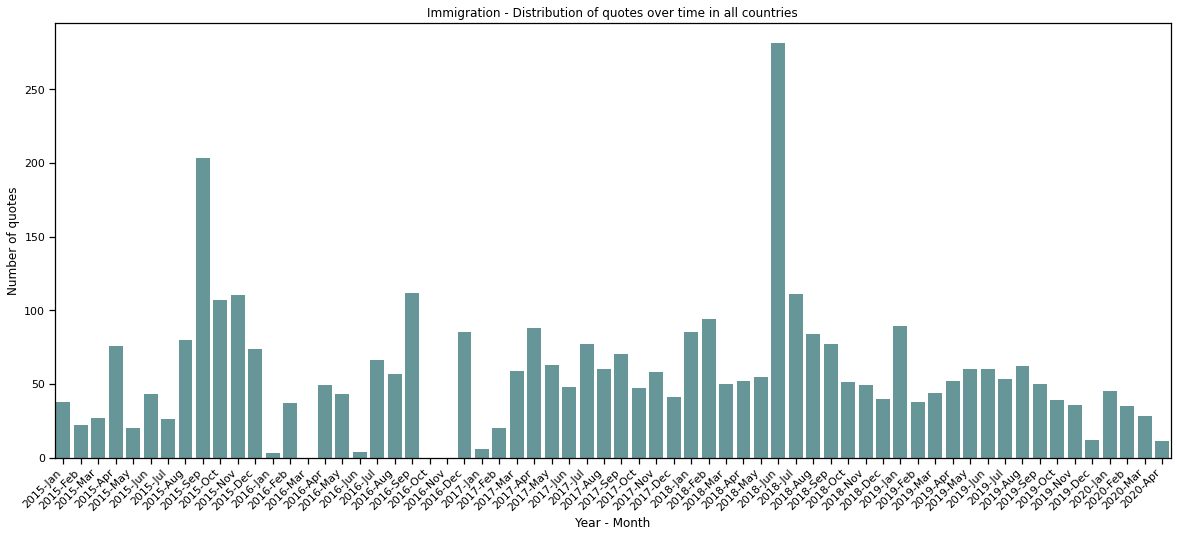

In [28]:
topic_name = 'Immigration'
df = immigration_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

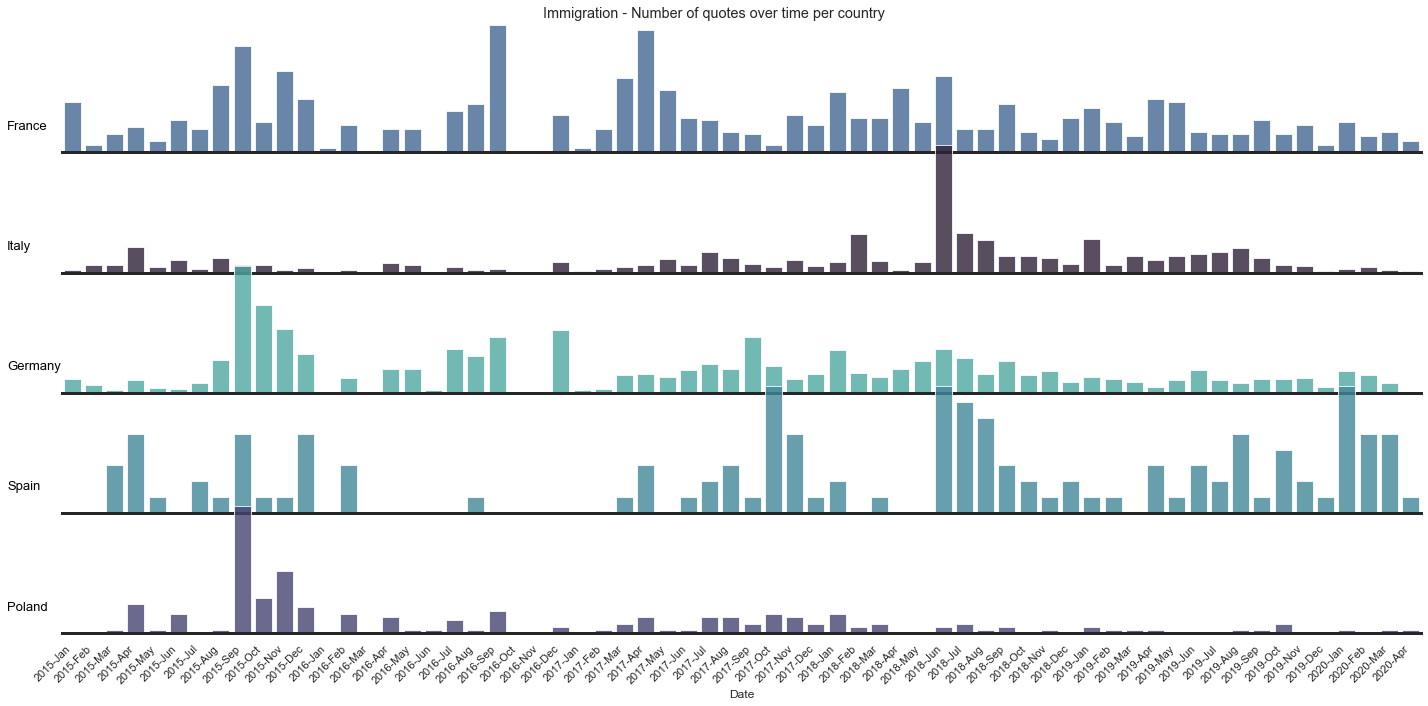

In [29]:
show_time_distribution_per_country(topic_name, df)

### Distribution over political alignments

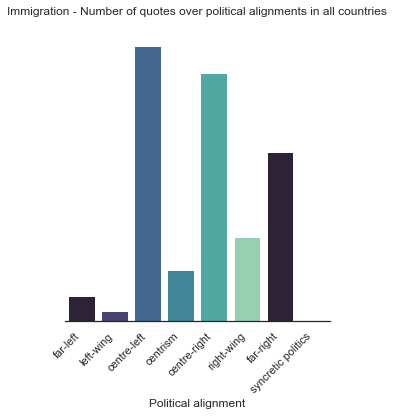

In [30]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

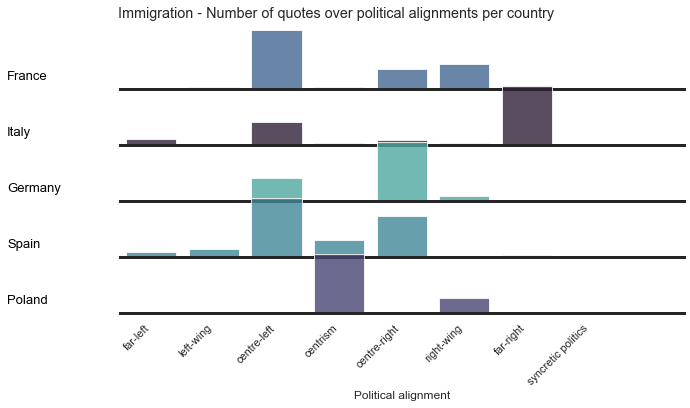

In [31]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

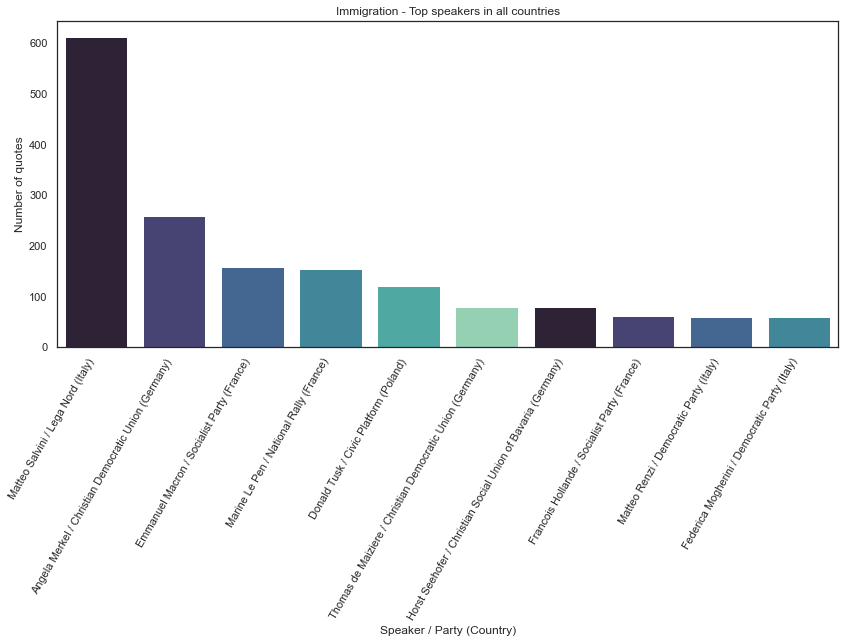

In [32]:
show_top_k_speakers(topic_name, df)

# European Union

### Distribution over time in all countries

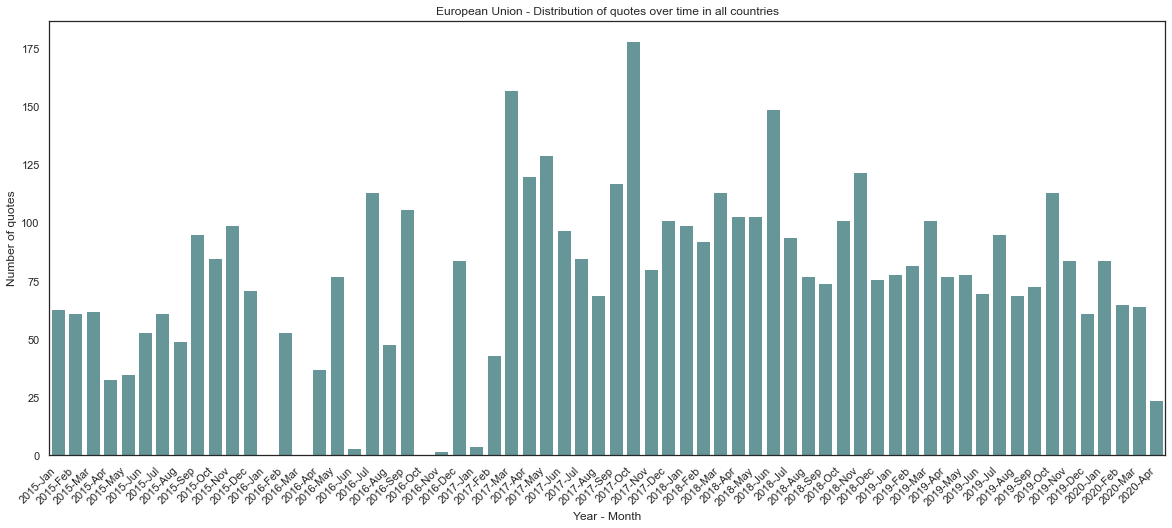

In [33]:
topic_name = 'European Union'
df = europe_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

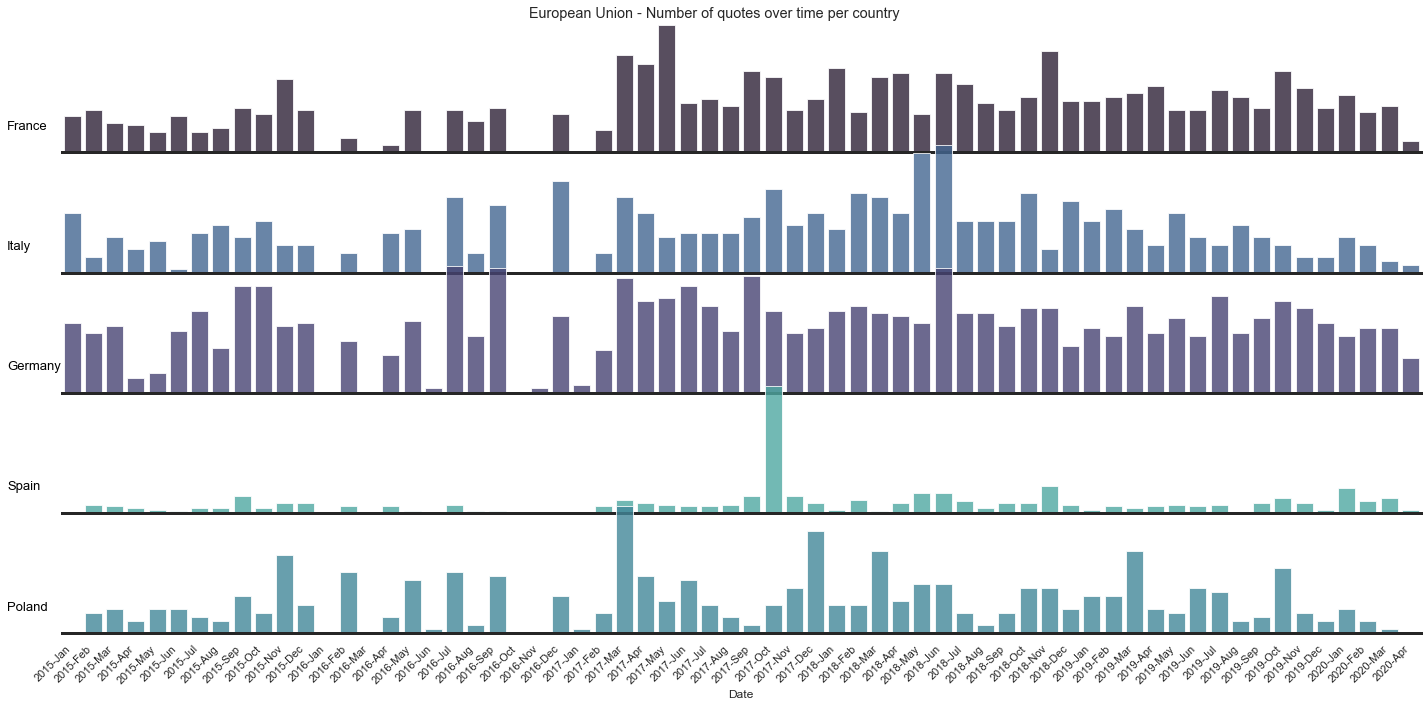

In [34]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

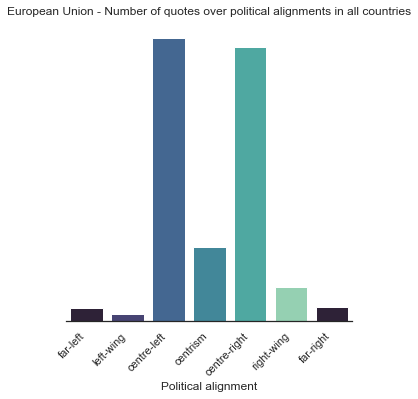

In [35]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

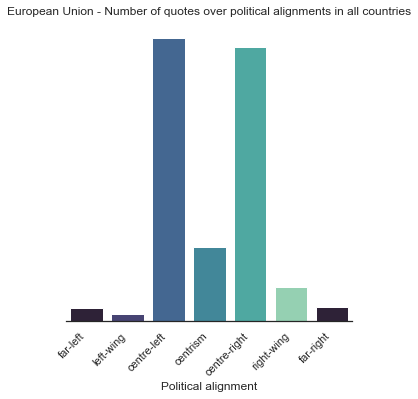

In [36]:
show_political_orientation_distribution(topic_name, df)

### Top speakers in all countries

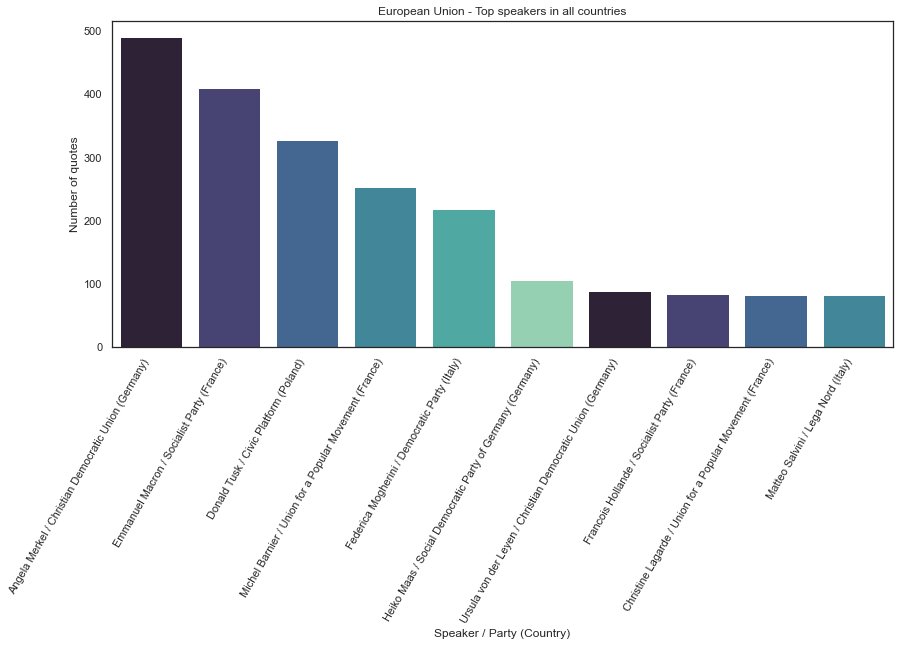

In [37]:
show_top_k_speakers(topic_name, df)


# Discriminations

### Distribution over time in all countries

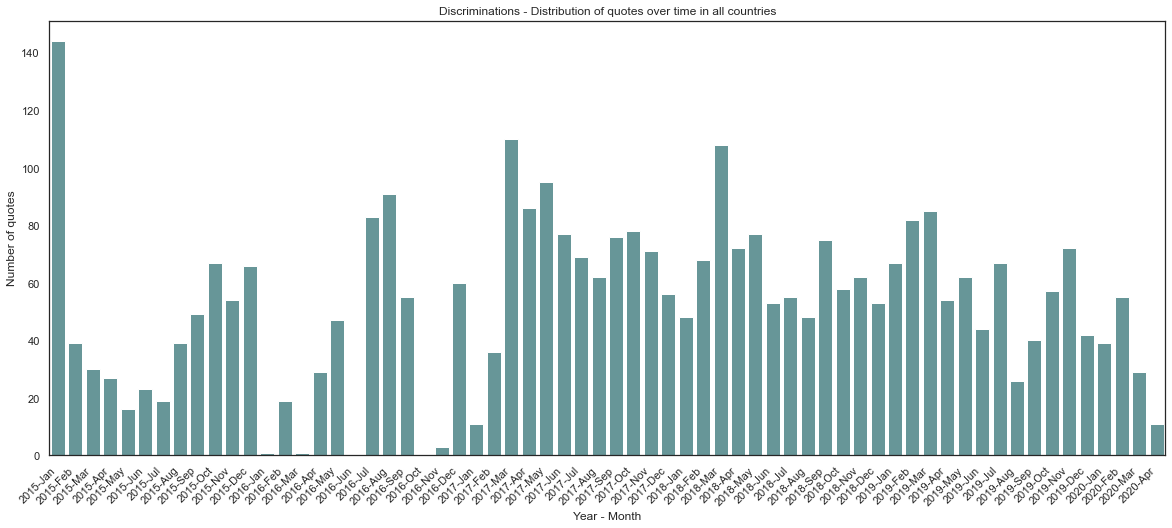

In [38]:
topic_name = 'Discriminations'
df = discrimination_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

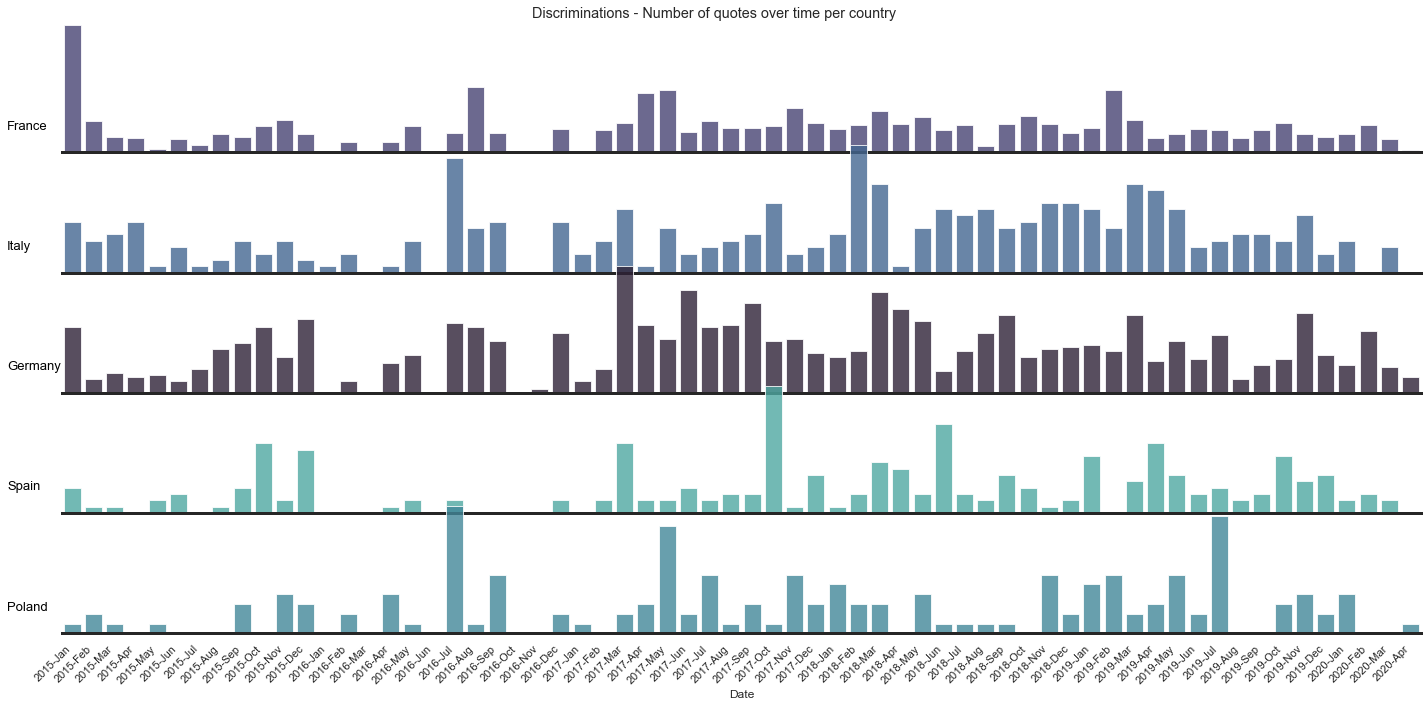

In [39]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

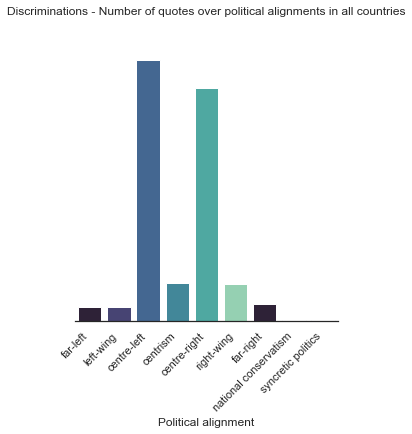

In [40]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

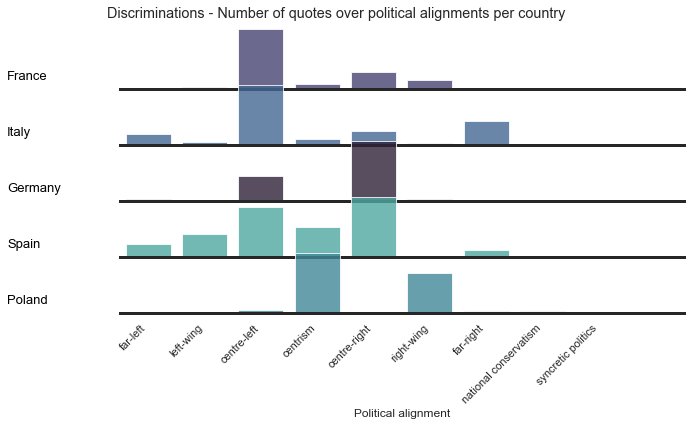

In [41]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

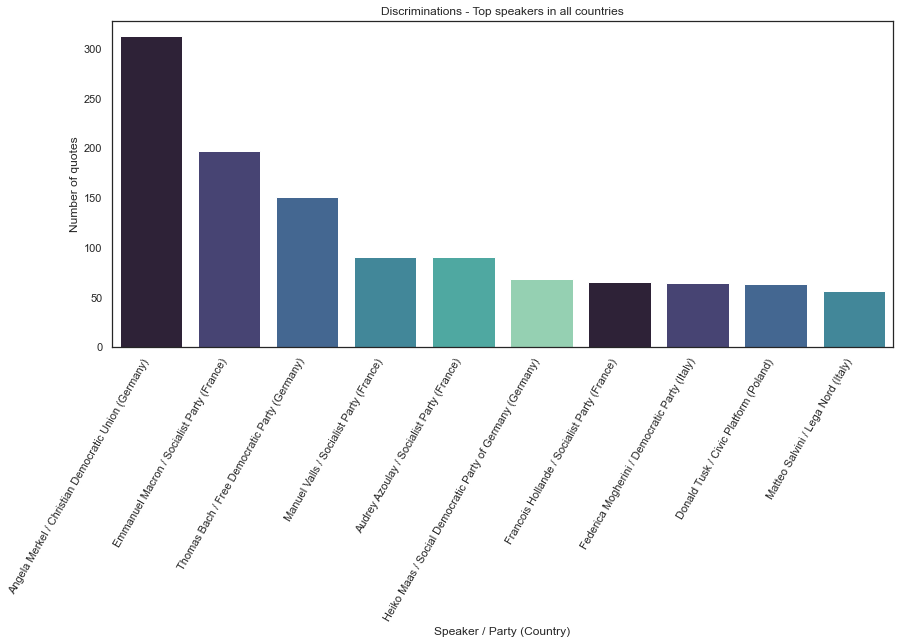

In [42]:
show_top_k_speakers(topic_name, df)

# Drugs

### Distribution over time in all countries

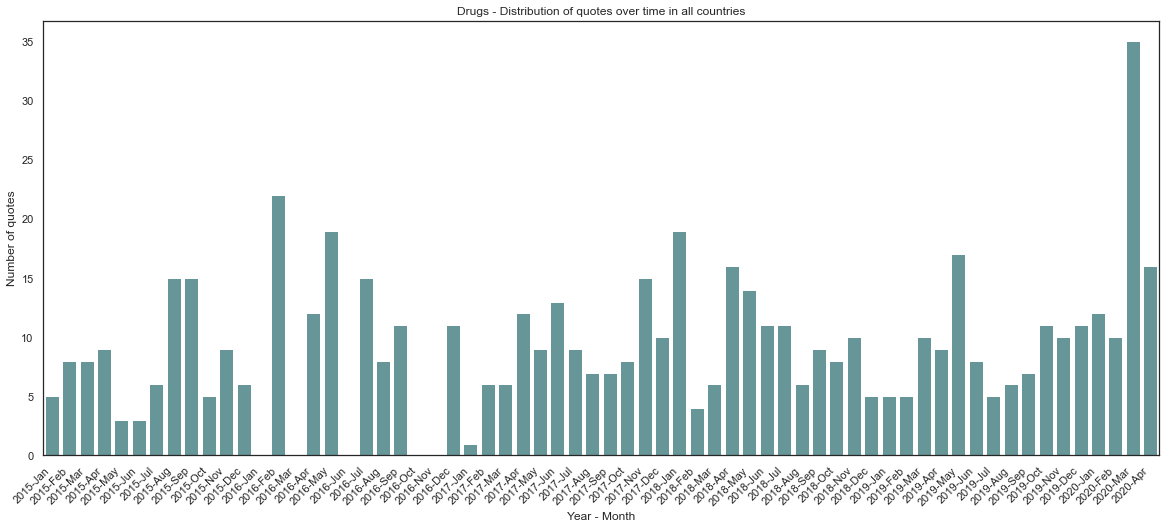

In [43]:
topic_name = 'Drugs'
df = drugs_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

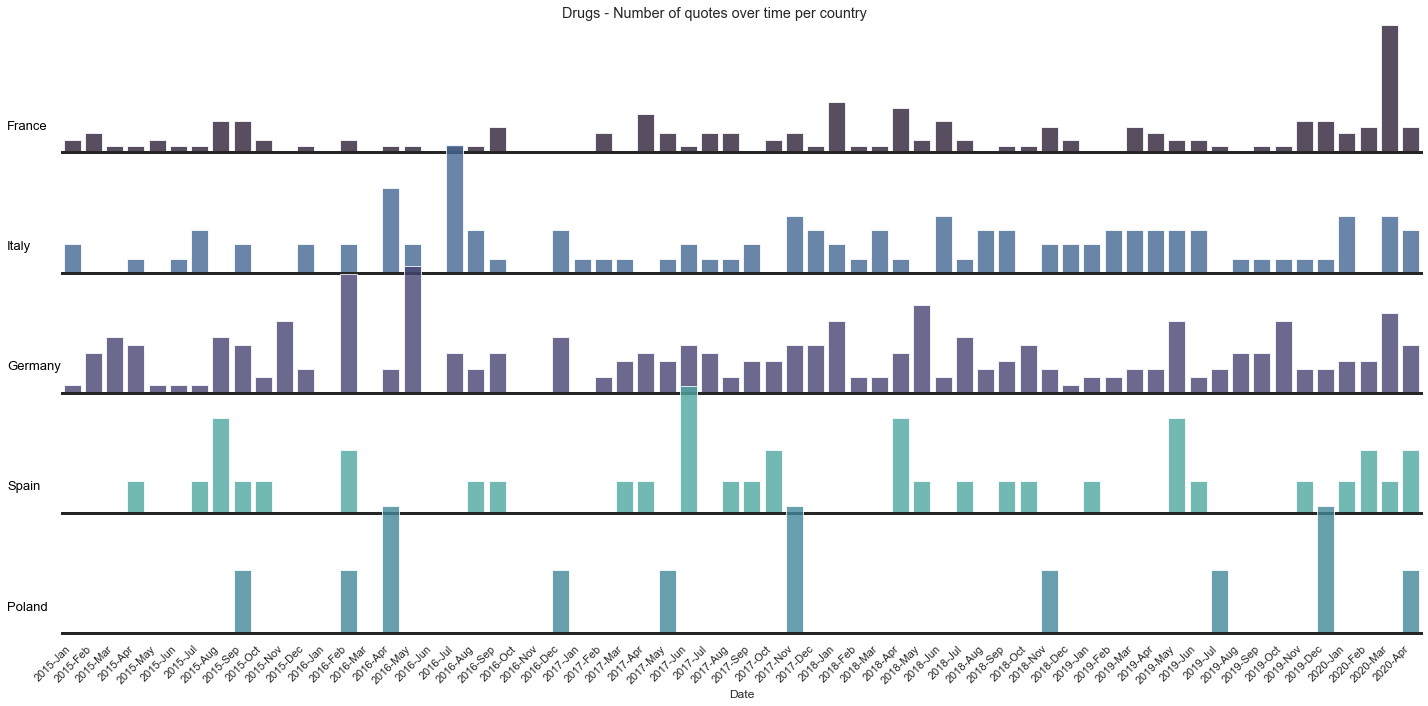

In [44]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

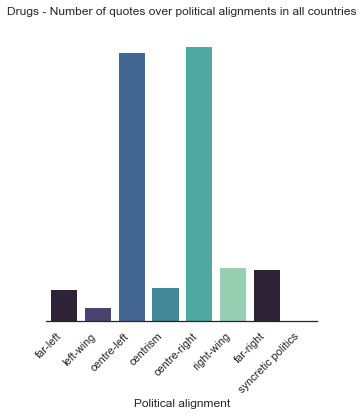

In [45]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

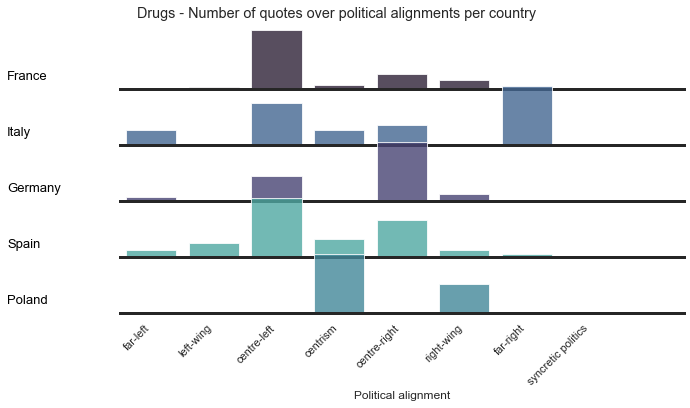

In [46]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

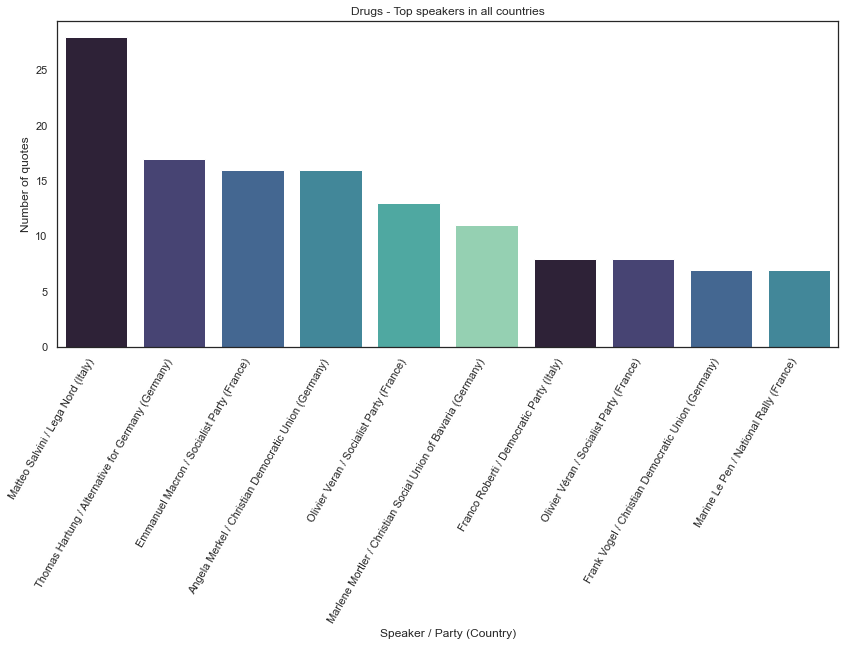

In [47]:
show_top_k_speakers(topic_name, df)


# Climate change

### Distribution over time in all countries

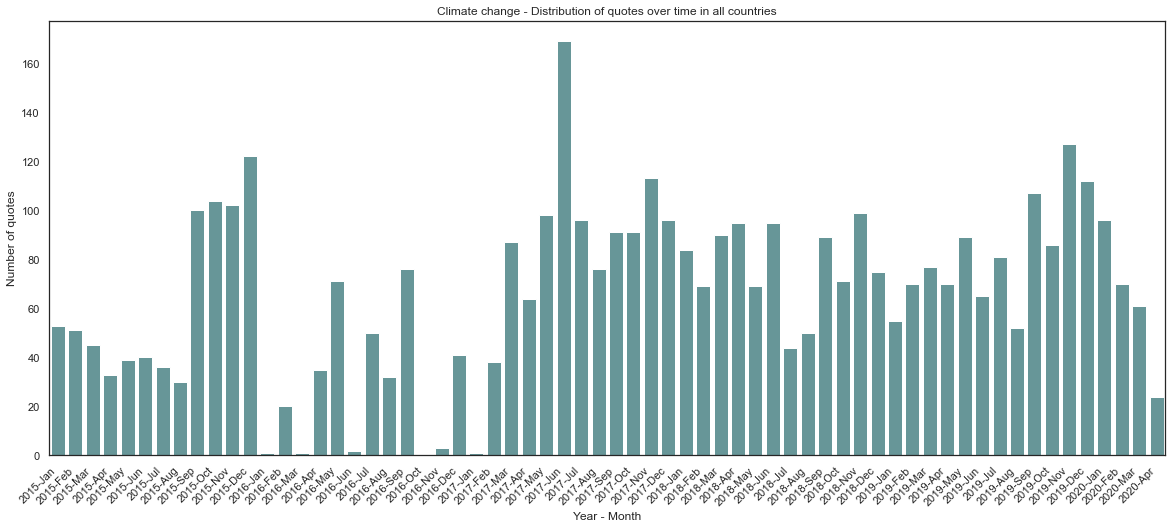

In [48]:
topic_name = 'Climate change'
df = climate_change_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

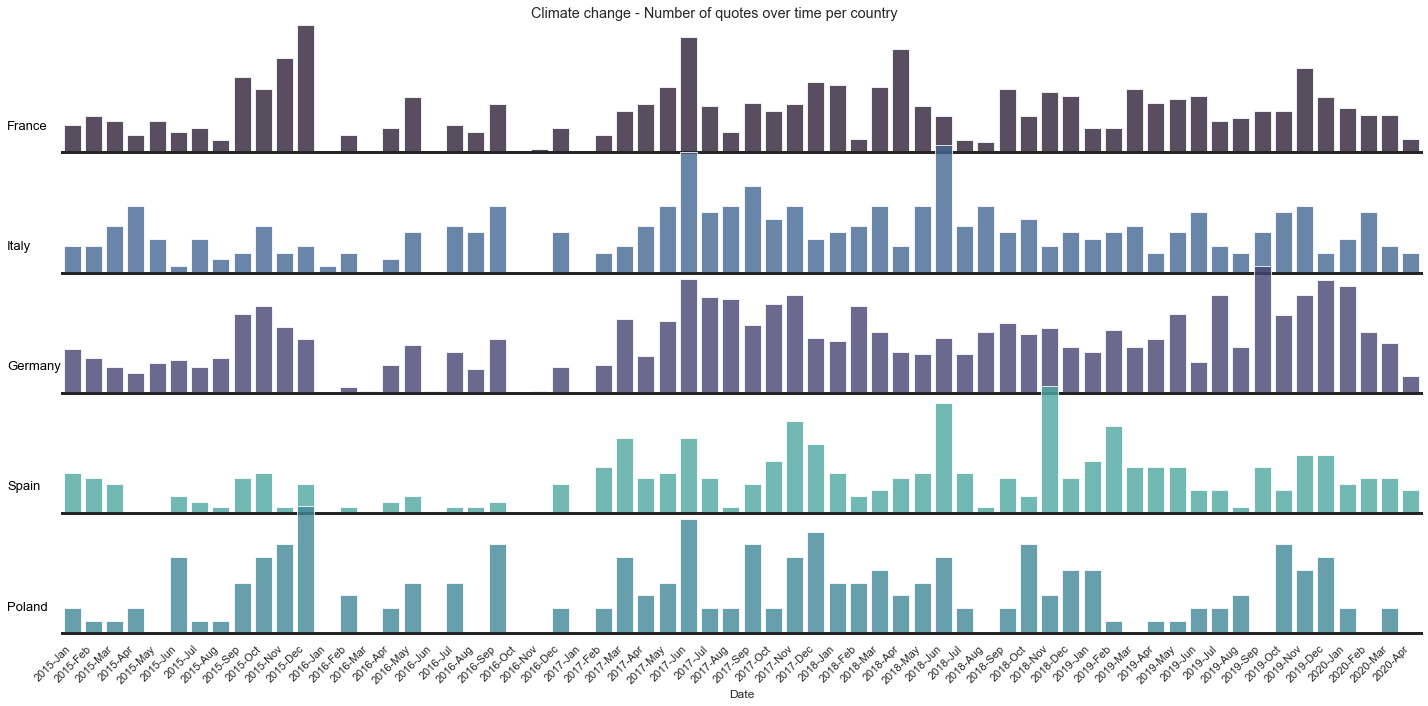

In [49]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

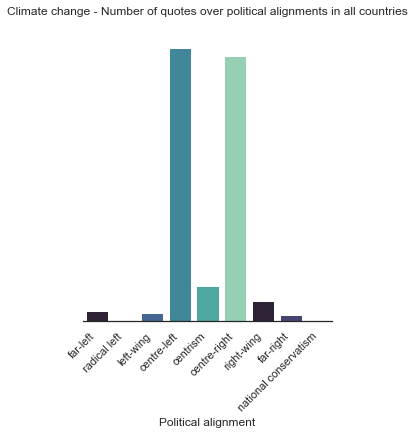

In [50]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

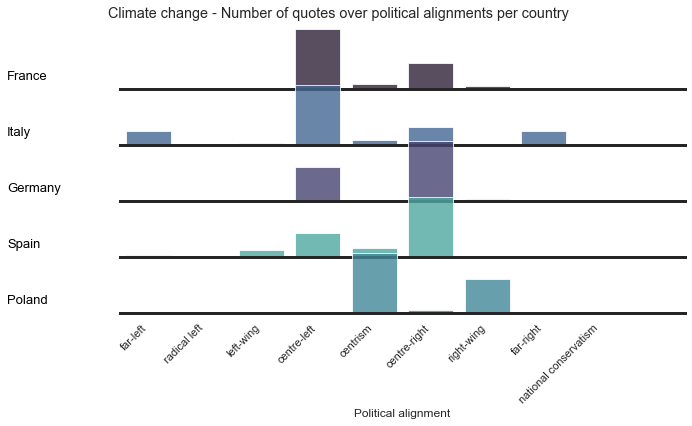

In [51]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

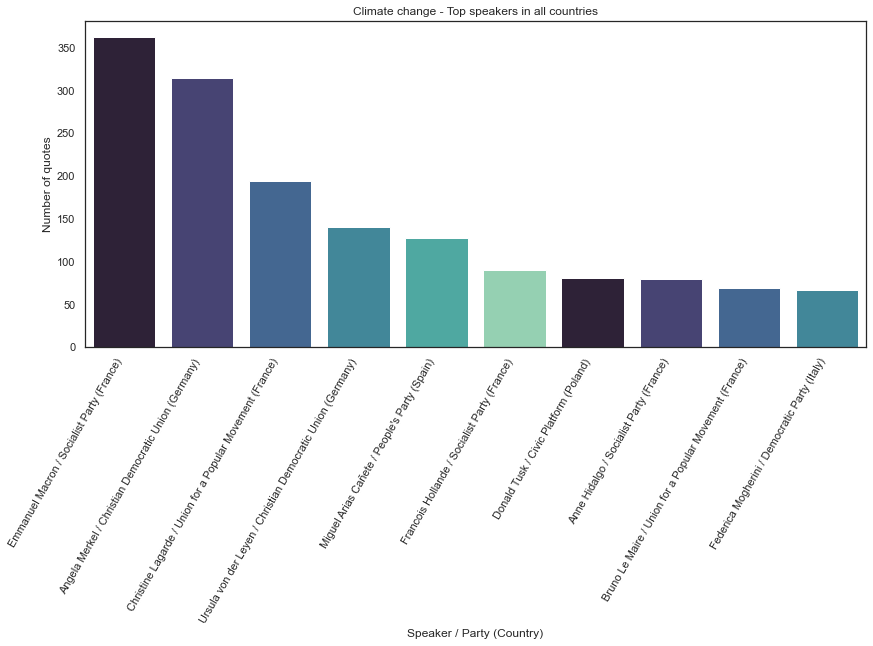

In [52]:
show_top_k_speakers(topic_name, df)

# Russia

### Distribution over time in all countries

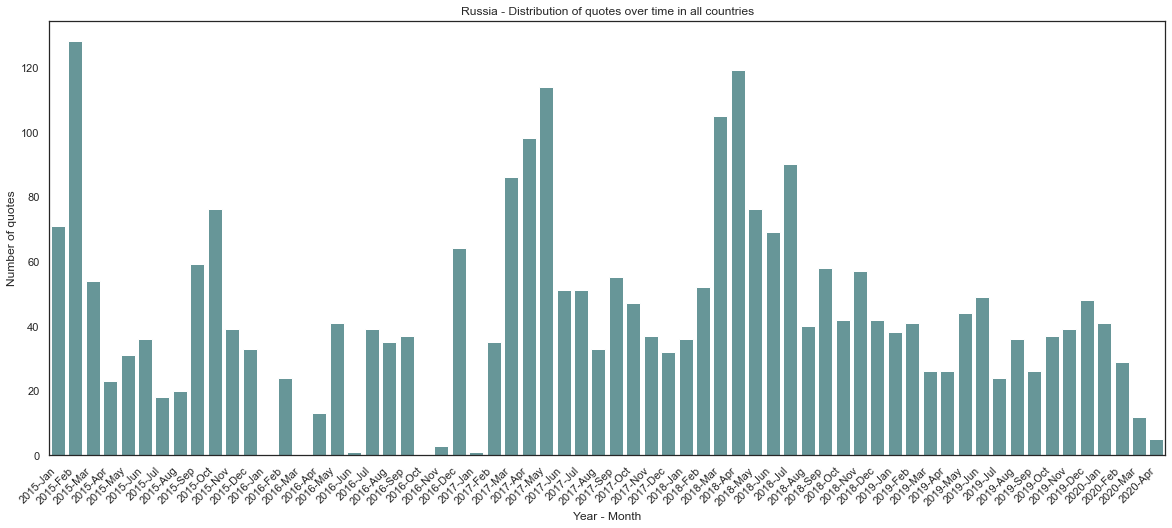

In [53]:
topic_name = 'Russia'
df = russia_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

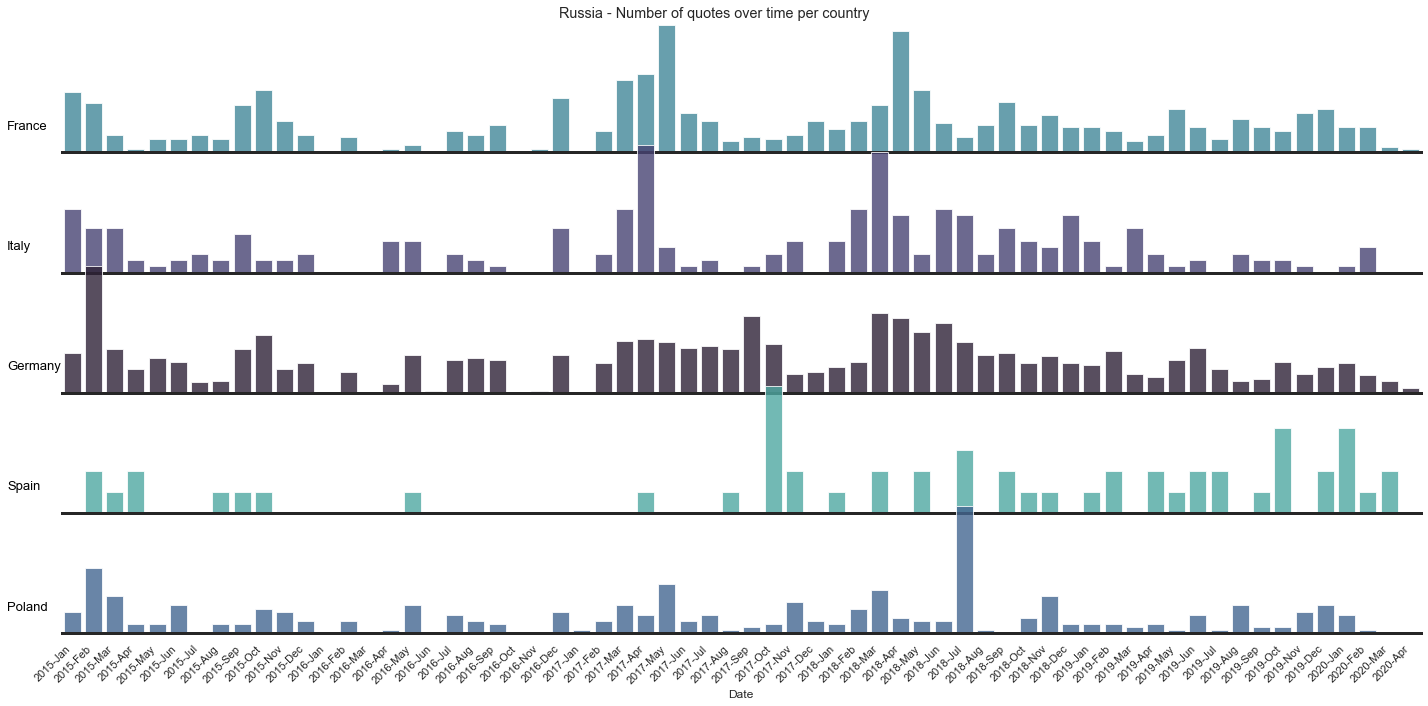

In [54]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

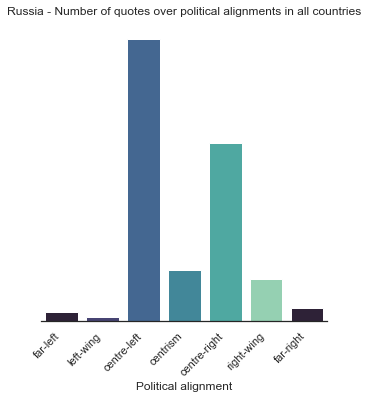

In [55]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

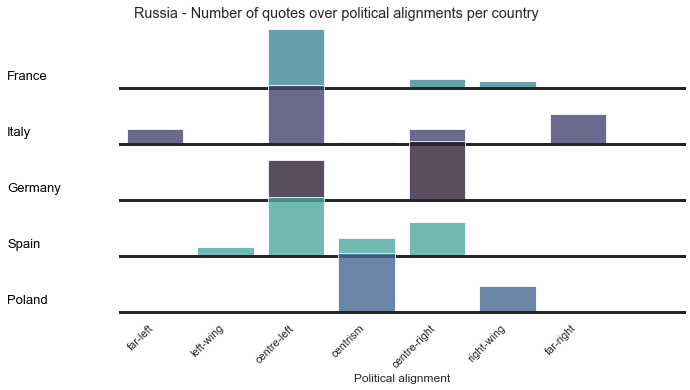

In [56]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

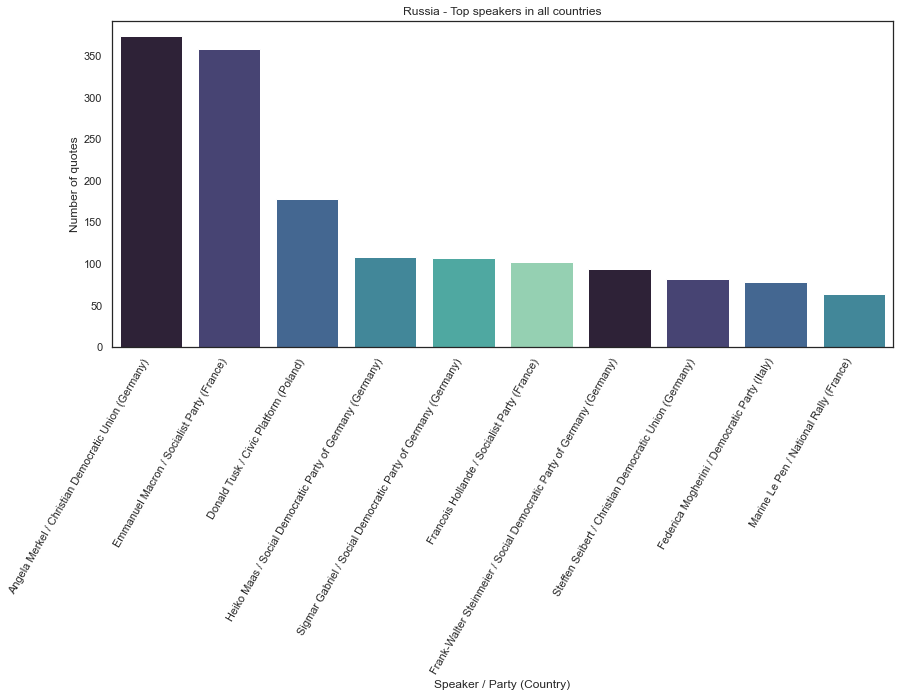

In [57]:
show_top_k_speakers(topic_name, df)


# Coronavirus

### Distribution over time in all countries

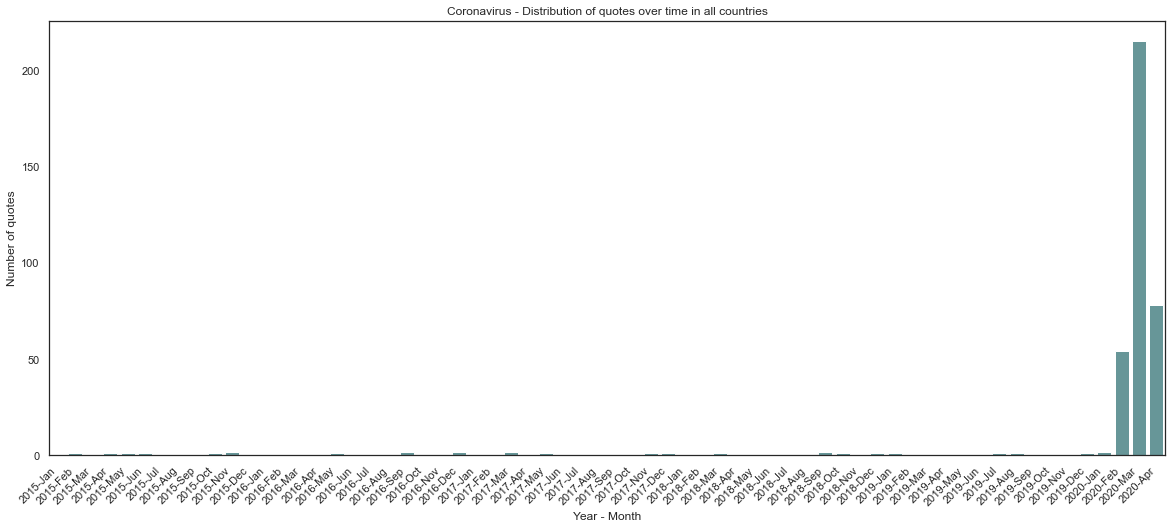

In [58]:
topic_name = 'Coronavirus'
df = covid_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

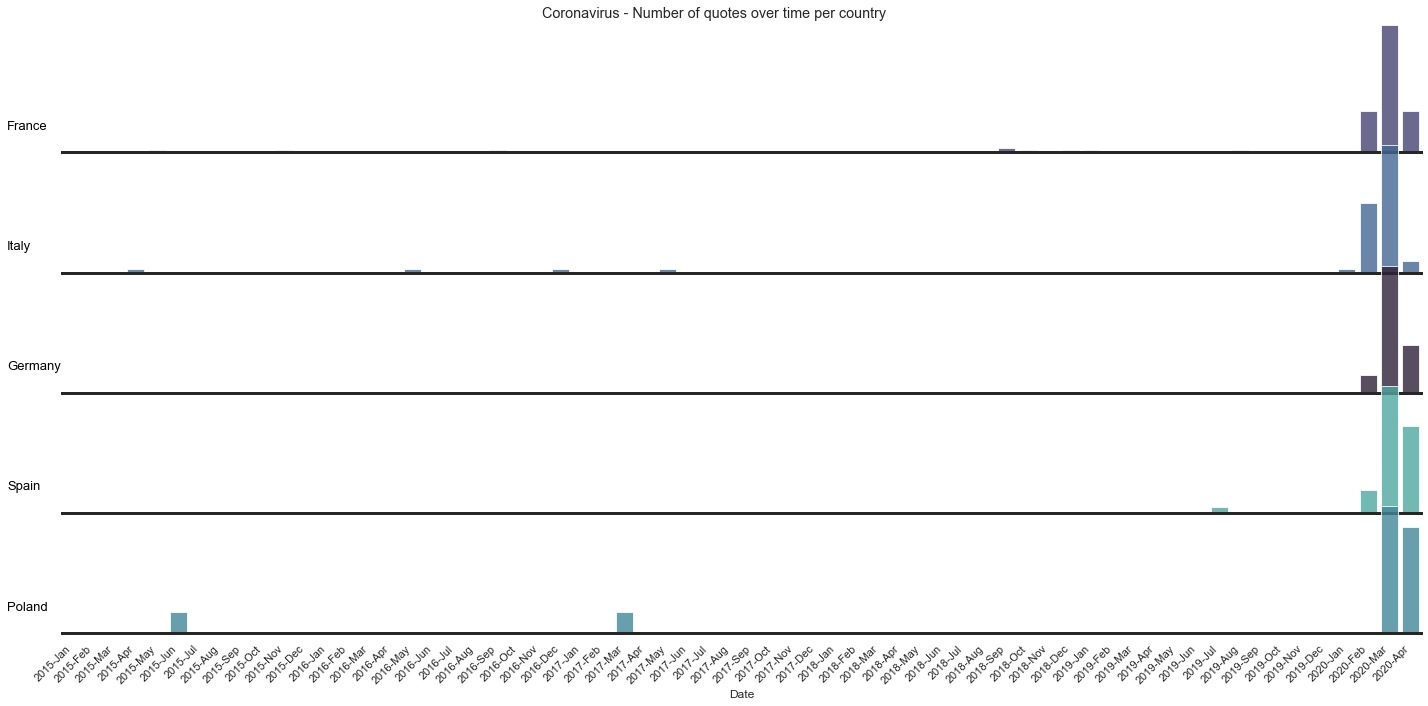

In [59]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

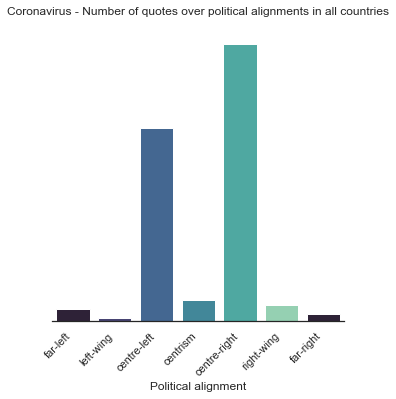

In [60]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

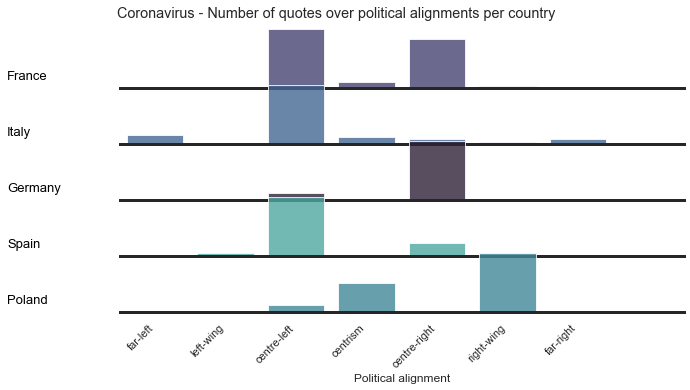

In [61]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

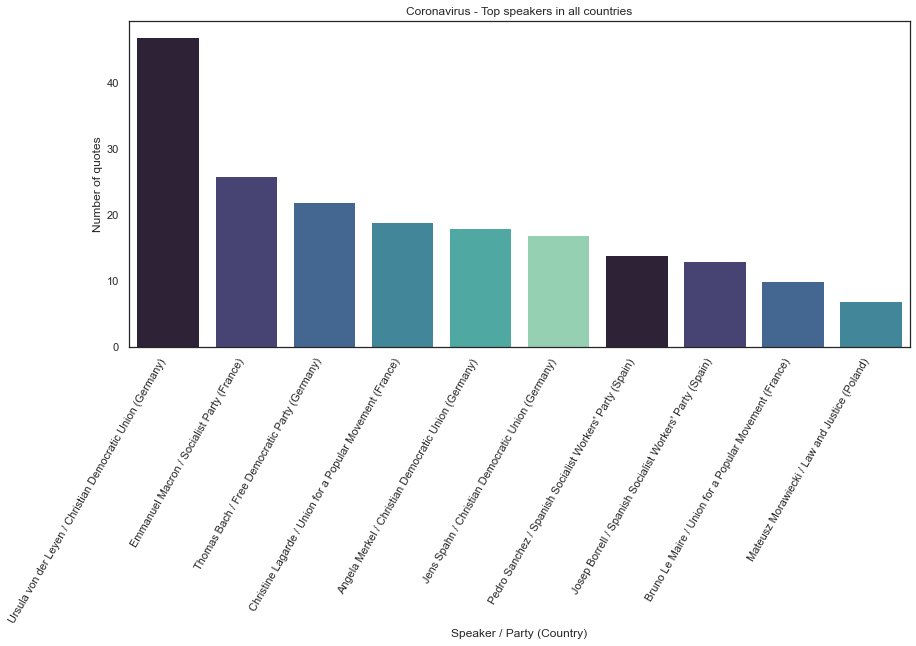

In [62]:
show_top_k_speakers(topic_name, df)

# Terrorism

### Distribution over time in all countries

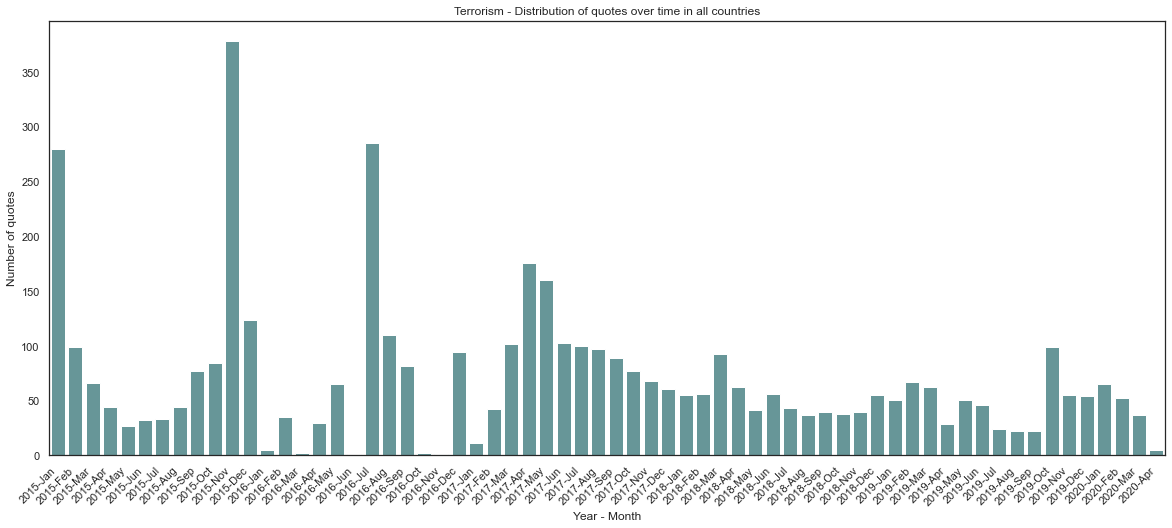

In [63]:
topic_name = 'Terrorism'
df = terrorism_quotes
show_time_distribution(topic_name, df)

### Distribution over time per country

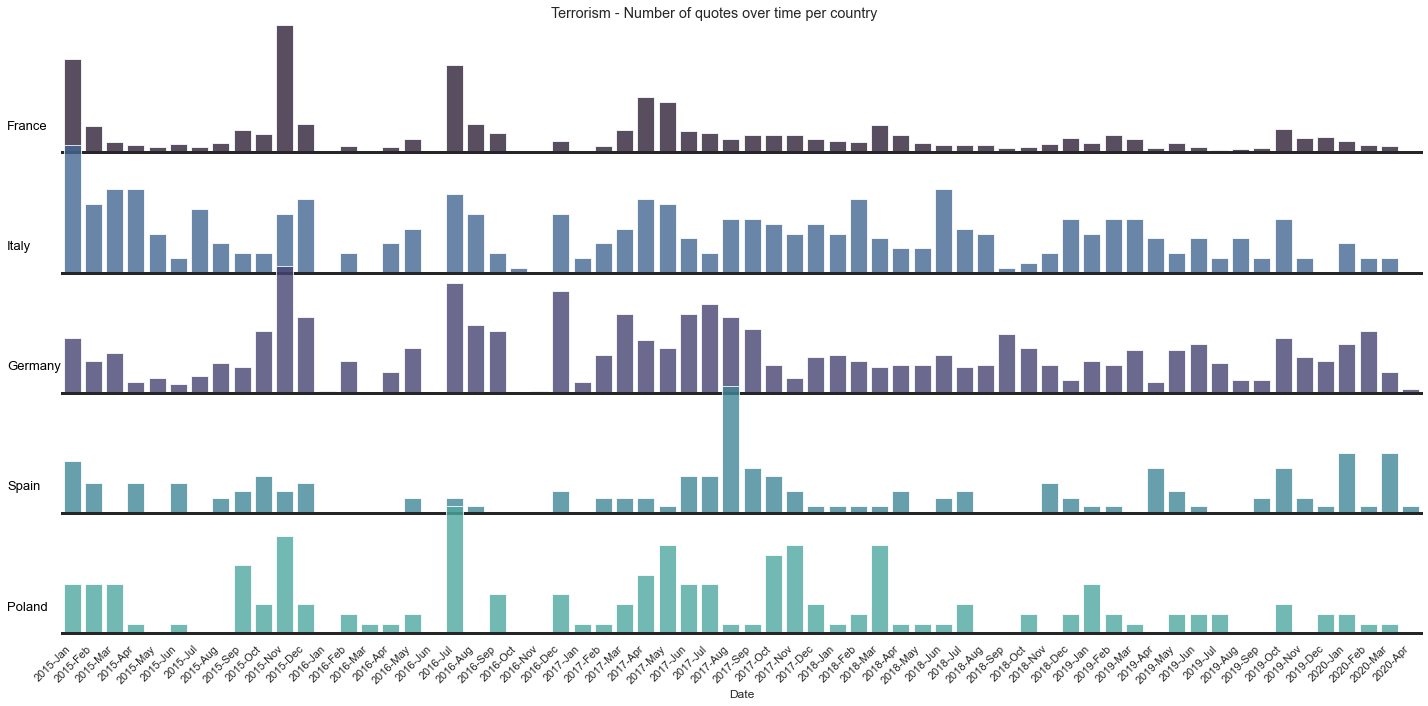

In [64]:
show_time_distribution_per_country(topic_name, df)


### Distribution over political alignments

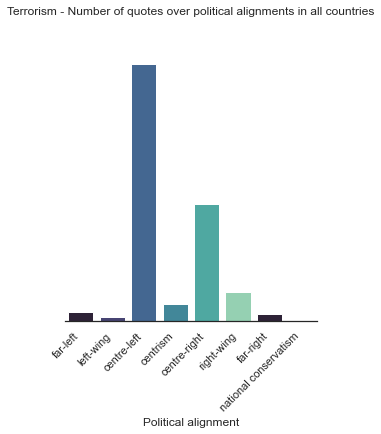

In [65]:
show_political_orientation_distribution(topic_name, df)

### Distribution over political alignments per country

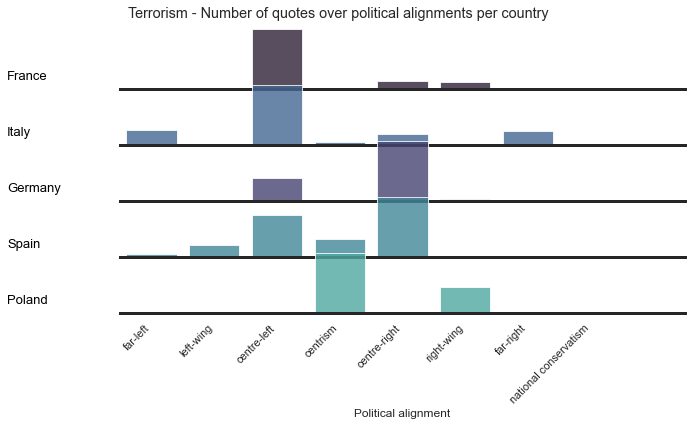

In [66]:
show_political_orientation_distribution_per_country(topic_name, df)

### Top speakers in all countries

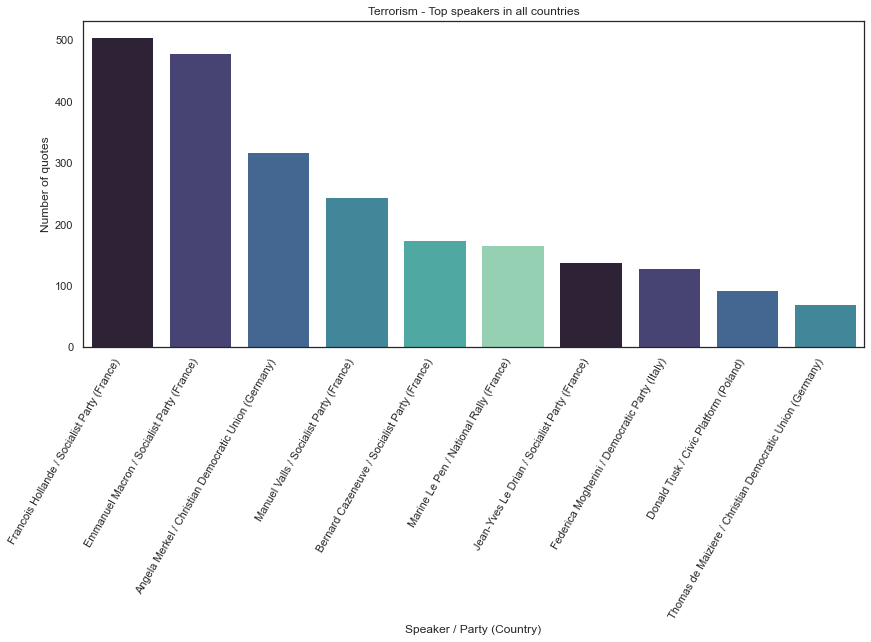

In [67]:
show_top_k_speakers(topic_name, df)

# Most popular topics per country

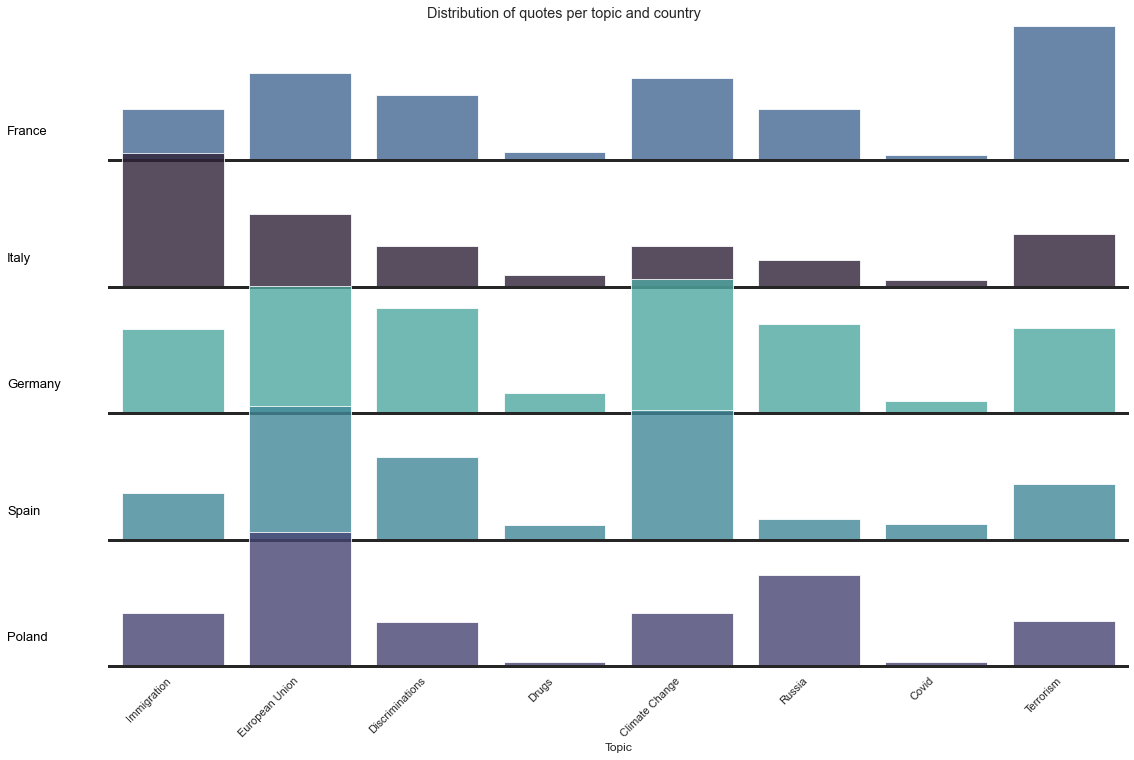

In [68]:
show_top_topics_per_country([immigration_quotes, europe_quotes, discrimination_quotes, drugs_quotes, climate_change_quotes, russia_quotes, covid_quotes, terrorism_quotes],
                            ["Immigration", "European Union", "Discriminations", "Drugs", "Climate change", "Russia", "Covid", "Terrorism"])